# Imports

In [1]:
# same seed to be reproducable
from numpy.random import seed
seed(888)
from tensorflow import random
random.set_seed(404)

In [32]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

# image dataset were used cifar 10
from keras.datasets import cifar10

from IPython.display import display
# from keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import array_to_img



%matplotlib inline

# Constants

In [3]:
LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS


VALIDATAION_SIZE = 10000
SMALL_TRAIN_SIZE  = 1000

# Get the Data

In [4]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [5]:
type(cifar10)

module

In [6]:
type(x_train_all)

numpy.ndarray

# Explore the Data

In [7]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

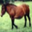

In [8]:
# in order to conver array to pic we use keras.preprocessing img_to_array
pic = array_to_img(x_train_all[7])
display(pic)

In [9]:
# we should be able to verify that this is indeed a horse by looking at the image labels which are found in the Y values.
y_train_all.shape
# we got numpy array of 50,000 labels and it's two dim

(50000, 1)

In [10]:
y_train_all[7][0]

7

In [11]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

In [ ]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]],fontsize=15) #insert label
plt.show()

**Challenge:** Write a for loop to display the first 10 images from the ```x_train_all``` array in a row. Show the name of the label below the picture. Remove the ugly tick marks. *Hint* use matplotlib. 

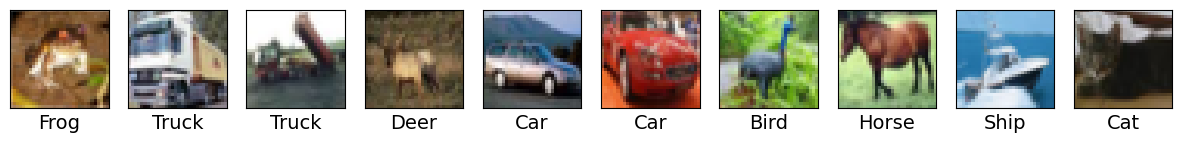

In [12]:
# the first 10 images in the training dataset
plt.figure(figsize=[15,5])

for i in range (10):
    plt.subplot(1,10,i+1)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]],fontsize=14)
    
    plt.imshow(x_train_all[i])

In [13]:
# how these images are formatted
x_train_all[0].shape #frog

(32, 32, 3)

In [14]:
# 4 dimension 50000 enteries,  
x_train_all.shape

(50000, 32, 32, 3)

In [15]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 50000 	| width = 32 	| height = 32 	| channels = 3


In [16]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [17]:
type(x_train_all[0][0][0][0])

numpy.uint8

In [18]:
# 255 is the largest value that I'm going to have because on the scale
# divide by 255 -> to get smaller value (easier later on for calculating the leraning rate and lost function and adjust them)
x_train_all, x_test = x_train_all / 255.0 , x_test/255.0

In [20]:
type(x_train_all[0][0][0][0])

numpy.float64

In [21]:
x_train_all = x_train_all.reshape(x_train_all.shape[0],TOTAL_INPUTS )#32*32*3

In [22]:
x_train_all.shape

(50000, 3072)

In [23]:
x_test = x_test.reshape(x_test.shape[0],TOTAL_INPUTS) # x_test.shape[0] = len(x_test)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


### Create Validation Dataset

In [26]:
x_val = x_train_all[:VALIDATAION_SIZE]
y_val = y_train_all[:VALIDATAION_SIZE] 
x_val.shape
#y_val.shape

(10000, 3072)

**Challenge:** Create two numpy arrays ```x_train``` and ```y_train``` that have the shape (40000, 3072) and (40000, 1) respectively. They need to contain the last 40000 values from ```x_train_all``` and ```y_train_all``` respectively. 

In [27]:
x_train = x_train_all[VALIDATAION_SIZE:] # gives us the last 40000 value from x
x_train.shape

(40000, 3072)

In [28]:
y_train = y_train_all[VALIDATAION_SIZE:]
y_train.shape

(40000, 1)

### Create a small dataset (for illustration)

In [29]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE] # take the fisrt 1000 value
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Activation


# Define the model
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu',name ='m1_hidden1'),
    Dense(units=64, activation = 'relu',name ='m1_hidden2'),
    Dense(16,activation='relu',name ='m1_hidden3'),
    Dense(10, activation='softmax',name ='m1_output')
])

# Compile the model
# 3 arguments: optimizer, the loss function, which metrics to calculate for optimizer

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']) 

In [39]:
type(model_1)

keras.engine.sequential.Sequential

In [40]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [41]:
32*32*3*128  # nr of connection weights

393216

In [42]:
393344-393216 # bias

128

In [43]:
32*32*3*128 +128 + (128*64 + 64) + (64*16+ 16) + (16*10 + 10)

402810